In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset as Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

<function matplotlib.pyplot.show(*args, **kw)>

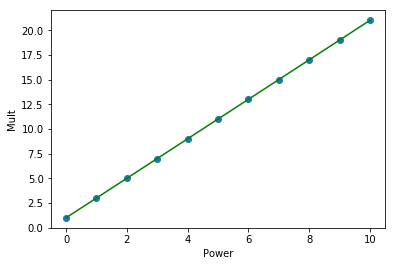

In [2]:
# Testing my pandas and mathlib.plot
targets = pd.Series([1,3,5,7,9,11,13,15,17,19,21])
features = pd.Series([0,1,2,3,4,5,6,7,8,9,10])
x = "Power"
y = "Mult"
plt.xlabel(x)
plt.ylabel(y)
dataset = pd.DataFrame({
    x : features,
    y : targets
})
plt.scatter(x= dataset[x], y= dataset[y])
x_ax0 = dataset[x].min()
x_ax1 = dataset[x].max()
y_ax0 = dataset[y].min()
y_ax1 = dataset[y].max()
plt.plot([x_ax0, x_ax1], [y_ax0, y_ax1], c = 'green')
plt.show

In [3]:
def input_fn(features, targets, batch_size = 1, shuffle = True, n_epochs = None):
    # Converts pandas to a dict of NumPy arrays
    features = {key: np.array(value) for key, value in dict(features).items()} 
    # Tensor_slices take tensor type in input (n, m) with n,m Natural. That is a vector/tuple  and return a dataset
    dataset = Dataset.from_tensor_slices((features, targets)).batch(batch_size).repeat(n_epochs)
    if shuffle:
        # buffer_size is the size of the dataset from which shuffle randomly shuffle
        dataset = dataset.shuffle(buffer_size = 10000)
    # Batch data
    return (dataset.make_one_shot_iterator().get_next())

In [6]:
def train(learning_rate, steps, batch_size, x, y):
    """Trains a linear regression model of one feature.
  
    Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
    """
  
    periods = 20
    steps_per_period = steps / periods

    
    feature_data = dataset[[x]]
    target = dataset[y]

    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column(x)]
  
    # Create input functions.
    training_input_fn = lambda:input_fn(feature_data, target, batch_size=batch_size)
    prediction_input_fn = lambda: input_fn(feature_data, target, n_epochs=1, shuffle=False)
  
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )

  # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(y)
    plt.xlabel(x)
    sample = dataset
    plt.scatter(sample[x], sample[y])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
    
        # Compute loss.
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, target))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[y].max()])
    
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % x)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                          sample[x].max()), 
                               sample[x].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["target"] = pd.Series(target)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 12.09
  period 01 : 11.49
  period 02 : 10.90
  period 03 : 10.30
  period 04 : 9.70
  period 05 : 9.10
  period 06 : 8.51
  period 07 : 7.91
  period 08 : 7.31
  period 09 : 6.72
  period 10 : 6.12
  period 11 : 5.52
  period 12 : 4.93
  period 13 : 4.33
  period 14 : 3.74
  period 15 : 3.14
  period 16 : 2.55
  period 17 : 1.96
  period 18 : 1.38
  period 19 : 0.82
Model training finished.


,predictions,target
count,11.0,11.0
mean,10.2,11.0
std,6.6,6.6
min,0.3,1.0
25%,5.2,6.0
50%,10.2,11.0
75%,15.1,16.0
max,20.1,21.0


Final RMSE (on training data): 0.82


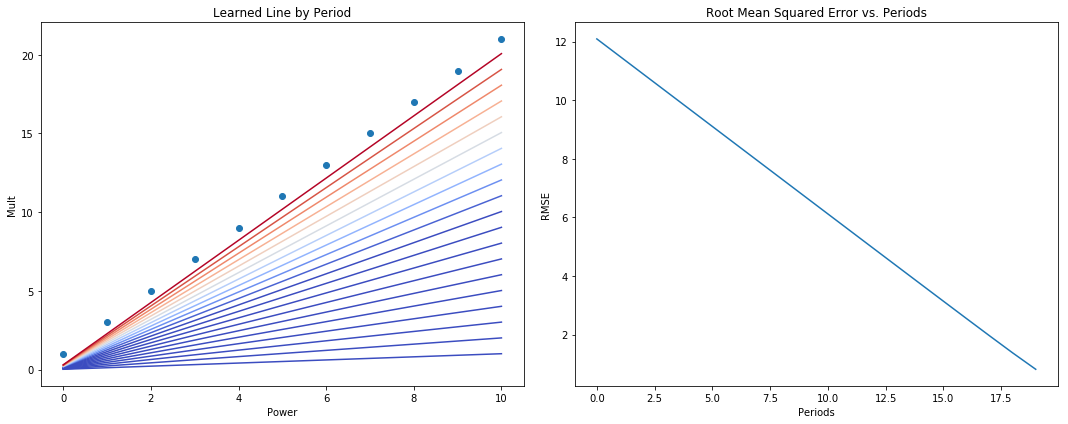

In [11]:
with tf.device('/gpu:0'):
    train(
        learning_rate=0.02,
        steps=7,
        batch_size=11,
        x = x,
        y = y
        )